In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import create_mask, metrics_AP, complete_nan_values
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
from model.models import UNET
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import gc
import json
import importlib
import numpy as np

## Parameters

In [3]:
with open(f'00_params.json') as param_file:
    params = json.load(param_file)

img_path = 'imgs' 
n_opt_layer = 26 #number of OPT layers, used to split de input data between OPT and SAR

number_class = 3
weights = params['weights']
times= params['times']
exp = params['exp']

overlap = params['overlap']
patch_size = params['patch_size']
batch_size = params['batch_size']

img_type = params['img_type']
cond = params['cond']
test_cond = params['test_cond']

nb_filters = params['nb_filters']

method = params['method']
module = importlib.import_module('model.models')
exp_model = getattr(module, method)

grid_size = params['grid_size']

tiles_tr = params['tiles_tr']
tiles_val = params['tiles_val']

In [4]:
print(f'Experiment: {exp}')
print(f'Test Cond: {test_cond}')
print(f'Model: {method}')

Experiment: 8
Test Cond: no_cloudy
Model: CrossFusion_ResUNET


In [5]:
path_exp = os.path.join(img_path, 'experiments', f'exp_{exp}')
path_models = os.path.join(path_exp, 'models')
path_maps = os.path.join(path_exp, 'pred_maps')

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [6]:
mean_prob_opt = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_opt.npy'))
mean_prob_sar = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_sar.npy'))
mean_prob_fus = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_fus.npy'))
mean_prob_comb = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_comb.npy'))

In [7]:
final_mask1 = np.lib.format.open_memmap(os.path.join(img_path, 'final_mask1.npy'))

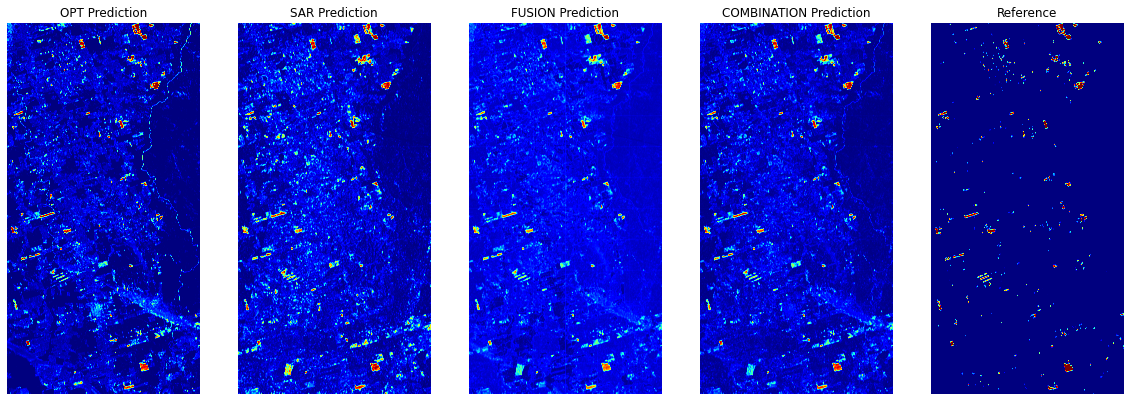

In [8]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(151)
plt.title('OPT Prediction')
ax1.imshow(mean_prob_opt, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(152)
plt.title('SAR Prediction')
ax1.imshow(mean_prob_sar, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(153)
plt.title('FUSION Prediction')
ax1.imshow(mean_prob_fus, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(154)
plt.title('COMBINATION Prediction')
ax1.imshow(mean_prob_comb, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(155)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')
plt.savefig(os.path.join(path_exp, 'pred.png'))

In [9]:
metrics_opt = np.load(os.path.join(path_exp, 'acc_metrics_opt.npy'))
metrics_sar = np.load(os.path.join(path_exp, 'acc_metrics_sar.npy'))
metrics_fus = np.load(os.path.join(path_exp, 'acc_metrics_fus.npy'))
metrics_comb = np.load(os.path.join(path_exp, 'acc_metrics_comb.npy'))

In [10]:
# Complete NaN values
metrics_copy_opt = np.array(metrics_opt)
metrics_copy_opt = complete_nan_values(metrics_copy_opt)

metrics_copy_sar = np.array(metrics_sar)
metrics_copy_sar = complete_nan_values(metrics_copy_sar)

metrics_copy_fus = np.array(metrics_fus)
metrics_copy_fus = complete_nan_values(metrics_copy_fus)

metrics_copy_comb = np.array(metrics_comb)
metrics_copy_comb = complete_nan_values(metrics_copy_comb)

OPT mAP 0.8334774021070699
SAR mAP 0.7486800924160871
FUSION mAP 0.8440713131702794
COMBINATION mAP 0.8599199322044377


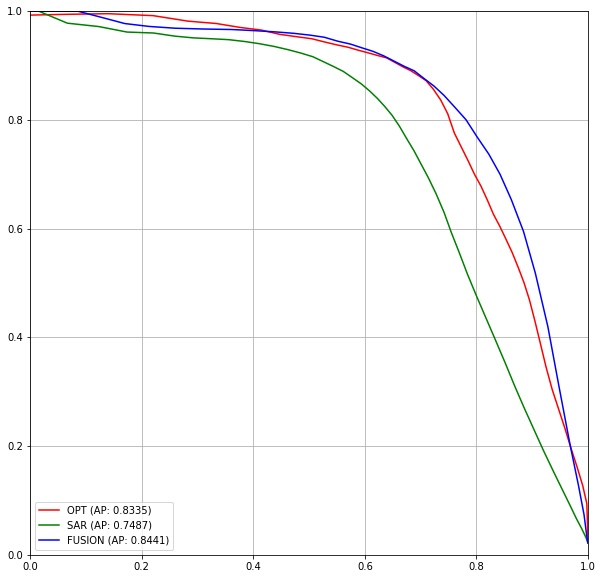

In [11]:
# Comput Mean Average Precision (mAP) score 
Recall_opt = metrics_copy_opt[:,0]
Precision_opt = metrics_copy_opt[:,1]
AA_opt = metrics_copy_opt[:,2]

Recall_sar = metrics_copy_sar[:,0]
Precision_sar = metrics_copy_sar[:,1]
AA_sar = metrics_copy_sar[:,2]

Recall_fus = metrics_copy_fus[:,0]
Precision_fus = metrics_copy_fus[:,1]
AA_fus = metrics_copy_fus[:,2]

Recall_comb = metrics_copy_comb[:,0]
Precision_comb = metrics_copy_comb[:,1]
AA_comb = metrics_copy_comb[:,2]
    
Recall_opt_ = np.insert(Recall_opt, 0, 0)
Precision_opt_ = np.insert(Precision_opt, 0, Precision_opt[0])
DeltaR_opt = Recall_opt_[1:]-Recall_opt_[:-1]
AP_opt = np.sum(Precision_opt_[1:]*DeltaR_opt)
print('OPT mAP', AP_opt)

Recall_sar_ = np.insert(Recall_sar, 0, 0)
Precision_sar_ = np.insert(Precision_sar, 0, Precision_sar[0])
DeltaR_sar = Recall_sar_[1:]-Recall_sar_[:-1]
AP_sar = np.sum(Precision_sar_[1:]*DeltaR_sar)
print('SAR mAP', AP_sar)

Recall_fus_ = np.insert(Recall_fus, 0, 0)
Precision_fus_ = np.insert(Precision_fus, 0, Precision_fus[0])
DeltaR_fus = Recall_fus_[1:]-Recall_fus_[:-1]
AP_fus = np.sum(Precision_fus_[1:]*DeltaR_fus)
print('FUSION mAP', AP_fus)

Recall_comb_ = np.insert(Recall_comb, 0, 0)
Precision_comb_ = np.insert(Precision_comb, 0, Precision_comb[0])
DeltaR_comb = Recall_comb_[1:]-Recall_comb_[:-1]
AP_comb = np.sum(Precision_comb_[1:]*DeltaR_comb)
print('COMBINATION mAP', AP_comb)

# Plot Recall vs. Precision curve
plt.figure(figsize=(10,10))
plt.plot(metrics_copy_opt[:,0],metrics_copy_opt[:,1], 'r-', label = f'OPT (AP: {AP_opt:.4f})')
plt.plot(metrics_copy_sar[:,0],metrics_copy_sar[:,1], 'g-', label = f'SAR (AP: {AP_sar:.4f})')
plt.plot(metrics_copy_fus[:,0],metrics_copy_fus[:,1], 'b-', label = f'FUSION (AP: {AP_fus:.4f})')
#plt.plot(metrics_copy_comb[:,0],metrics_copy_comb[:,1], 'k-', label = f'COMBINATION (AP: {AP_comb:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()
plt.savefig(os.path.join(path_exp, 'result.png'))